# Stock Price Prediction From Employee / Job Market Information
## Modelling: Linear Model
Objective utilise the Thinknum LinkedIn and Job Postings datasets, along with the Quandl WIKI prices dataset to investigate the effect of hiring practices on stock price. In this notebook I'll begin exploring the increase in predictive power from historic employment data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob

# Utilities
from utils import *

%matplotlib inline
PATH = Path('D:\data\jobs')

In [ ]:
link, companies, stocks = data_load(PATH)

Let's start with some of the series that had the most promising cross correlations.

In [28]:
filtered = companies.sort_values('max_corr',ascending=False)[['dataset_id', 'company_name','MarketCap', 'Sector', 'Symbol',
                                                   'max_corr', 'best_lag']]
filtered = filtered.query('(max_corr > 0.95) & (best_lag < -50)')
filtered.head()

,dataset_id,company_name,MarketCap,Sector,Symbol,max_corr,best_lag
1525,929840,"USA Truck, Inc.",$149.71M,Transportation,USAK,0.986638,-70.0
467,868114,Intuitive Surgical,$56.29B,Health Care,ISRG,0.986286,-90.0
1800,1341298,USANA Health Sciences,$2.73B,Consumer Durables,USNA,0.983291,-60.0
1347,908733,Insulet Corporation,$4.89B,Health Care,PODD,0.982384,-120.0
1546,957640,Nektar Therapeutics,$6.34B,Health Care,NKTR,0.979169,-160.0


Modelling for the top stock here USA Truck Inc.

In [4]:
USAK = stocks.USAK
USAK_link = link[link['dataset_id']==929840]['employees_on_platform']

In [5]:
start = min(USAK_link.index)
end = max(USAK_link.index)

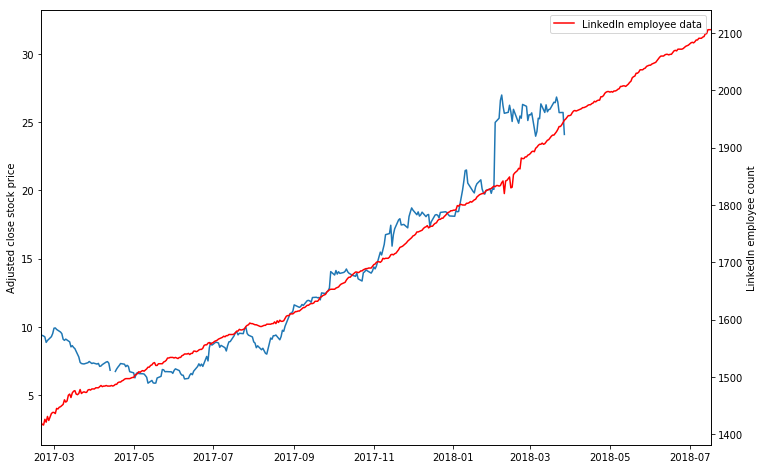

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlim(start,end)
ax.plot(USAK.index,USAK, label='Adjusted Close Price (USAK)')
ax.set_ylabel('Adjusted close stock price')
ax1=ax.twinx()
ax1.set_ylabel('LinkedIn employee count')
ax1.plot(USAK_link.index, USAK_link,color='r',label='LinkedIn employee data')
plt.legend();

In [7]:
def build_t_feats(stock,employ,n, include_employ=True):
    if include_employ:
        X = pd.concat([stock,employ],axis=1)
        X.columns = ['close','emps']
    else:
        X = pd.DataFrame(stock)
        X.columns = ['close']
    y=None
    
    start = max(pd.datetime(2016,7,1),min(stock.dropna().index)) - pd.Timedelta(1, unit='d')
    end = max(stock.dropna().index)
    
    X = X.loc[start:end]
    
    # Normalize
    X = (X-X.mean())/X.std()
       
    # Fill gaps
    X = X.interpolate()
    
    # Daily returns
    X = X.diff()
    
    # Create target variable
    X['y'] = X.close.shift(-1)
    
    # Create time shifted features
    for t in range(n):
        X['c'+str(t+1)] = X.close.shift(t+1)
        if include_employ: X['e'+str(t+1)] = X.emps.shift(t+1)
    
    X = X.dropna()
    
    y = X.y
    X.drop('y',axis=1,inplace=True)
    
    return X,y

X, y = build_t_feats(USAK,USAK_link,180)

## Linear Model
Start with a basic linear model, so we can easily interpret the model outputs.

Mean absolute error:  0.05485194746799064 
Split scores:  [0.0214873  0.03508219 0.03497026 0.05428902 0.0430487  0.03043928
 0.0585213  0.1008948  0.08044345 0.08934317]


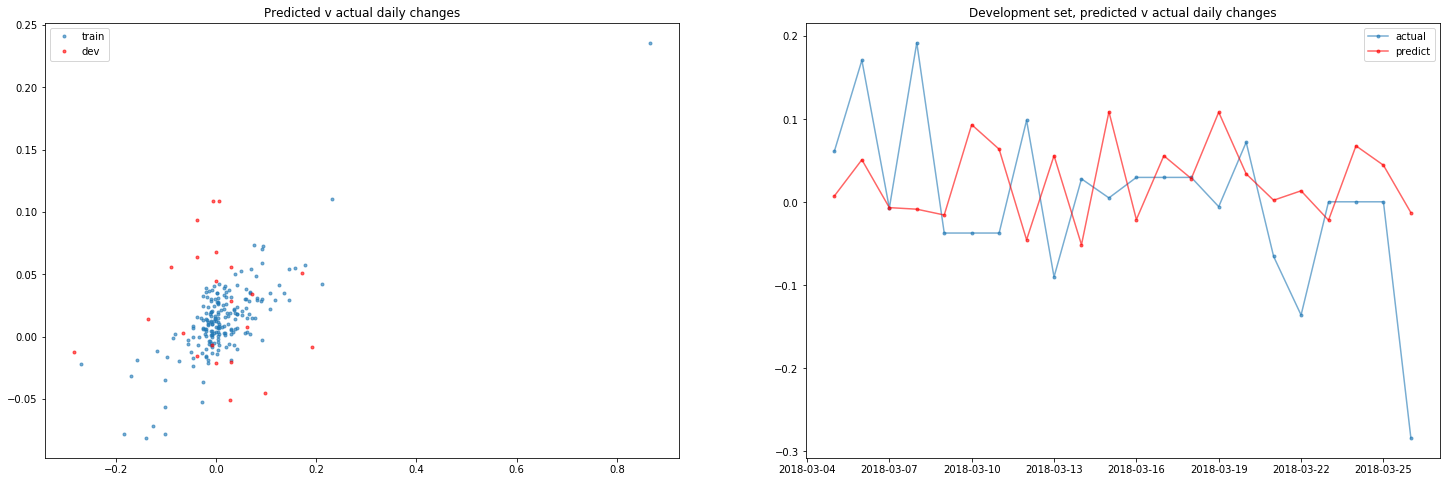

In [8]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error

reg = Ridge()

def fit_predict(reg, X, y, plot=True):
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(reg, X, y, cv=cv, scoring='neg_mean_absolute_error')
    if plot: print('Mean absolute error: ', np.mean(-scores), '\nSplit scores: ',-scores)

    cut = int(X.shape[0]*0.9)
    X_train, y_train = X[:cut], y[:cut].values.reshape(-1,1)
    X_dev, y_dev = X[cut:], y[cut:].values.reshape(-1,1)

    reg.fit(X_train,y_train)

    pred_dev = reg.predict(X_dev)
    pred_train = reg.predict(X_train)
    
    if plot:
        f,ax = plt.subplots(nrows=1,ncols=2,figsize=(25,8))
        ax[0].plot(y_train,pred_train,marker='.',linestyle='None',alpha=0.6,label='train')
        ax[0].plot(y_dev,pred_dev,marker='.',linestyle='None',color='r',alpha=0.6,label='dev')
        ax[0].set_title('Predicted v actual daily changes')
        ax[0].legend()

        ax[1].plot(X[cut:].index,y_dev,alpha=0.6,label='actual',marker='.')
        ax[1].plot(X[cut:].index,pred_dev,color='r',alpha=0.6,label='predict',marker='.')
        ax[1].set_title('Development set, predicted v actual daily changes')
        ax[1].legend();
    
    return reg, np.mean(-scores)

reg, _ = fit_predict(reg, X, y)

Using MAE (Mean Absolute Error) as the evaluation metric here. Around 0.05 MAE seems acceptable at predicting the daily changes.

In [9]:
coefs = reg.coef_.ravel()
idx = coefs.argsort()[-40:]

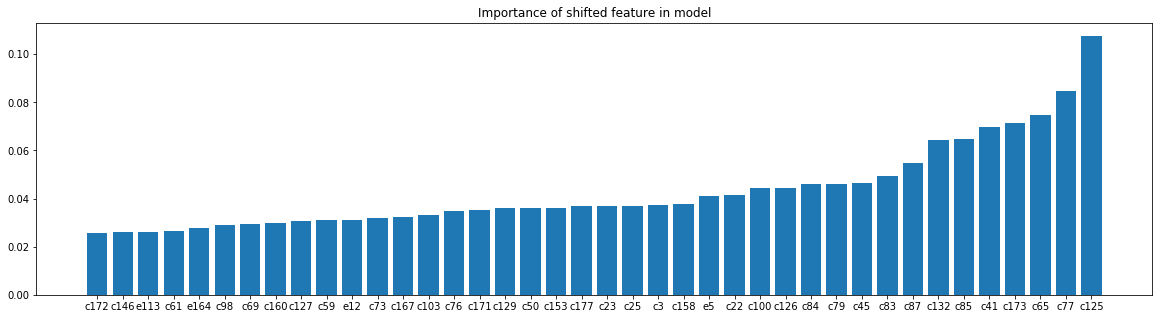

In [10]:
x = np.arange(len(coefs[idx]))
fig,ax = plt.subplots(figsize=(20,5))
plt.bar(x,coefs[idx])
plt.xticks(x,X.columns.values[idx])
plt.title('Importance of shifted feature in model')
plt.show();

Looks like most of the top features are time lagged versions of the daily price change rather than the employment data.

## Same model excluding employment data
I'll now rerun the same analysis but exluced the employment data.

In [11]:
X, y = build_t_feats(USAK,USAK_link,180,include_employ=False)

Mean absolute error:  0.0607687153067917 
Split scores:  [0.02911067 0.04328596 0.03876474 0.04835429 0.03579512 0.04716982
 0.07197536 0.06298087 0.10960007 0.12065024]


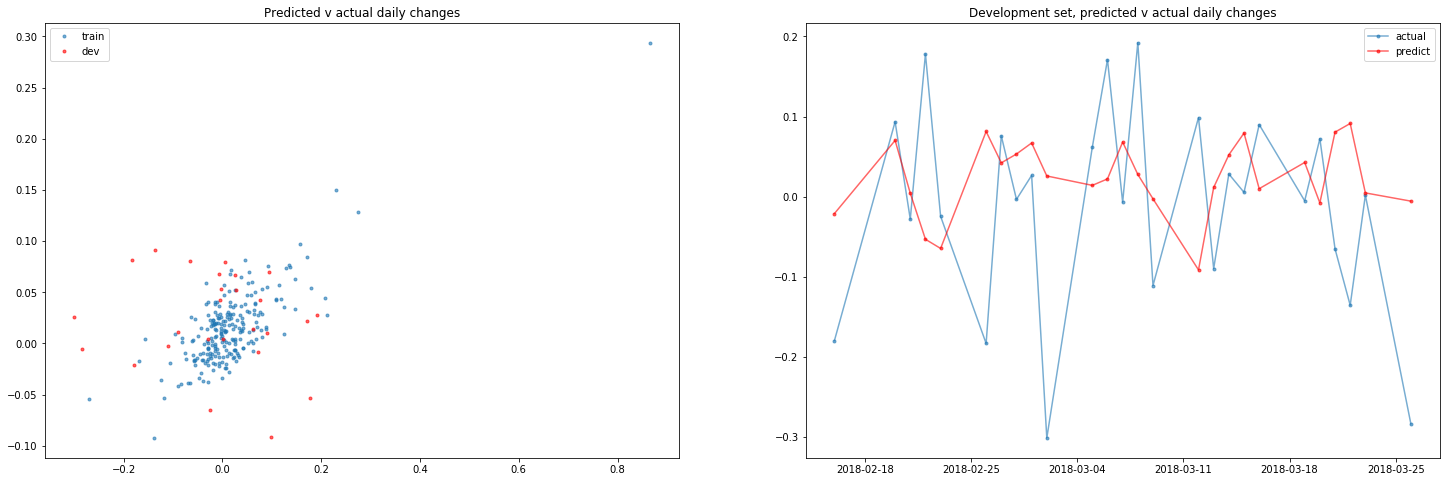

In [12]:
reg = Ridge()
reg, _ = fit_predict(reg, X, y)

In [13]:
coefs = reg.coef_.ravel()
idx = coefs.argsort()[-40:]

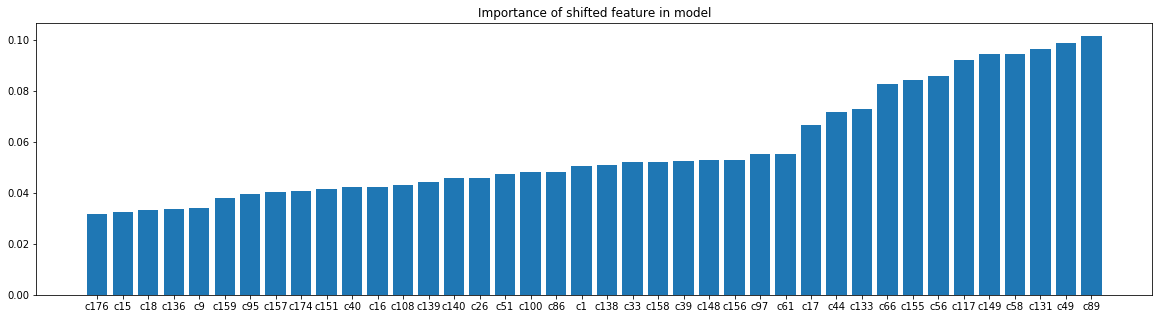

In [14]:
x = np.arange(len(coefs[idx]))
fig,ax = plt.subplots(figsize=(20,5))
plt.bar(x,coefs[idx])
plt.xticks(x,X.columns.values[idx])
plt.title('Importance of shifted feature in model')
plt.show();

Over a similar time period it looks like our model performed better using employment data.

## Rerun analysis for all top stocks

In [39]:
filtered = filtered[filtered.dataset_id != 868877].copy()

In [ ]:
MAEs = np.full((len(filtered),2),np.nan)
for i,ID in enumerate(filtered.dataset_id.values):
    print(i, ID, filtered.set_index('dataset_id').loc[ID].company_name)
    
    try:
        sym = filtered.set_index('dataset_id').loc[ID].Symbol
        tick = stocks[sym]
        emp = link[link['dataset_id']==ID]['employees_on_platform']
    except:
        print('Symbol Error, Skipping')
    
    # Including employee data
    X, y = build_t_feats(tick,emp,180,True)
    reg = Ridge()
    reg, MAE = fit_predict(reg, X, y, plot=False)
    MAEs[i][0] = MAE
    
    # Excluding employee data
    X, y = build_t_feats(tick,emp,180,False)
    reg = Ridge()
    reg, MAE = fit_predict(reg, X, y, plot=False)
    MAEs[i][1] = MAE

In [41]:
filtered['MAE_w_emp'] = MAEs[:,0]
filtered['MAE_wo_emp'] = MAEs[:,1]

In [71]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

In [73]:
TOOLS="hover,save"
p1 = figure(plot_width=600, plot_height=600, title="Prediction score with and without LinkedIn data",tools=TOOLS)
p1.xgrid.grid_line_color = None
p1.circle(x='MAE_wo_emp', y='MAE_w_emp', size=12, alpha=0.5, source=filtered)
p1.line(x=np.arange(0,0.25,0.01),y=np.arange(0,0.25,0.01))

p1.xaxis.axis_label = 'MAE with employee data in model'
p1.yaxis.axis_label = 'MAE without employee data in model'

hover = p1.select(dict(type=HoverTool))
hover.tooltips = [
        ("Name", "@company_name"),
        ("Correlation", "@max_corr"),
        ("Optimal Lag", "@best_lag"),
        ]

show(p1)

The vast majority of points fall below the line, meaning the predictions generated with a simple linear model were improved when Employee data was included in the model. **Therefore the LinkedIn data does improve the predictions of future stock price movements.**